In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

operator_names = ("Conjunction", "Disjunction", "Filter", "Average", "Join", "SelfJoin", "Stream", "Sequence")

def is_operator_name(file):
    if file.__contains__("~lock"):
        return False
    
    for op in operator_names:
        if file.__contains__(op):
            return True
    return False


if __name__ == '__main__':
    sample_filepath = os.path.join("/home/niels/Downloads/data_collection/linear_road/sampling_15s")
    sample_files = ['']
    for root, dirs, files in os.walk(sample_filepath):
        if not dirs:
            sample_files = [y for x in os.walk(sample_filepath) for y in (glob(os.path.join(x[0], '*.csv')))]
        else:
            # sort by name, in case of sim runs with increasing data rates
            dirs.sort()
            for dirname in dirs:
                files = (glob(os.path.join(os.path.join(root, dirname), '*.csv')))
                #sort by edit time
                if files is not None:
                    files.sort(key=lambda x: os.stat(os.path.join(sample_filepath, x)).st_mtime)
                    sample_files.extend(files)

    #sample_files = [y for x in os.walk(sample_filepath) for y in (glob(os.path.join(x[0], '*.csv')))]
    sample_files = [ file for file in sample_files if is_operator_name(file) ]
    #sample_files.sort(key=lambda x: os.stat(os.path.join(sample_filepath, x)).st_mtime)
    print(len(sample_files), sample_files)
    default_header = ["Relaxation",	"Rizou", "ProducerConsumer", "Random", "GlobalOptimalBDP", "MDCEP",
                      "eventSizeInKB",	"eventSizeOutKB",	"operatorSelectivity",	"eventRateIn",
                      "interArrivalMean",	"interArrivalStdDev",	"networkParentLatencyMean",	"networkParentLatencyStdDev",
                      "processingLatencyMean", 	"processingLatencyStdDev",	"brokerCPULoad",	"brokerThreadCount",
                      "brokerOperatorCount",	"brokerOtherBandwidthInKB",	"brokerOtherBandwidthOutKB",
                      "e2eLatencyMean",	"eventRateOut"
                      ]


    samples = pd.DataFrame()
    discarded_lines = 0
    for filename in sample_files:
        path = os.path.join(sample_filepath, filename)
        if os.path.isfile(path):
            #print("processing ", path)
            with open(path) as f:
                df = pd.read_csv(f, sep=";", header=0)._get_numeric_data()
                if df.columns[0] == "0" or df.columns[0] == "1":
                    #print("found file with zero in header ", f, df.columns)
                    df.columns = default_header
                    #print(df.head)

                if not df.empty:
                    df = df.dropna()
                     #filter irrelevant lines
                    size_before = len(df.index)
                    df = df[ df["eventSizeInKB"] > 0]
                    df = df[ df["eventSizeOutKB"] > 0]
                    df = df[ df["eventRateIn"] > 0]
                    df = df[ df["e2eLatencyMean"] > 0]
                    size_after = len(df.index)
                    #print("discarded ", size_before - size_after)
                    discarded_lines += size_before - size_after
                    samples = samples.append(df)
        else:
            print("invalid path: ", path)
            
    #print(samples)
    print("total samples: ", len(samples.index), ", discarded: ", discarded_lines)
    samples.to_csv(sample_filepath + '/combined_samples.csv', index=False, sep=';')

1110 ['/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Stream1c85dade2--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Conjunction1147624820--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Conjunction1180080605--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Conjunction11e427a20e--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Stream1a35689e6--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-NewAverage179e9ad00--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Stream1f4c65348--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Conjunction119c4292c3--721861497.csv', '/home/niels/Downloads/data_collection/linear_road/sampling_15s/stats-Stream1d7bc0ed8--721861497.csv', '/home/niels/Downloads/data_collection/

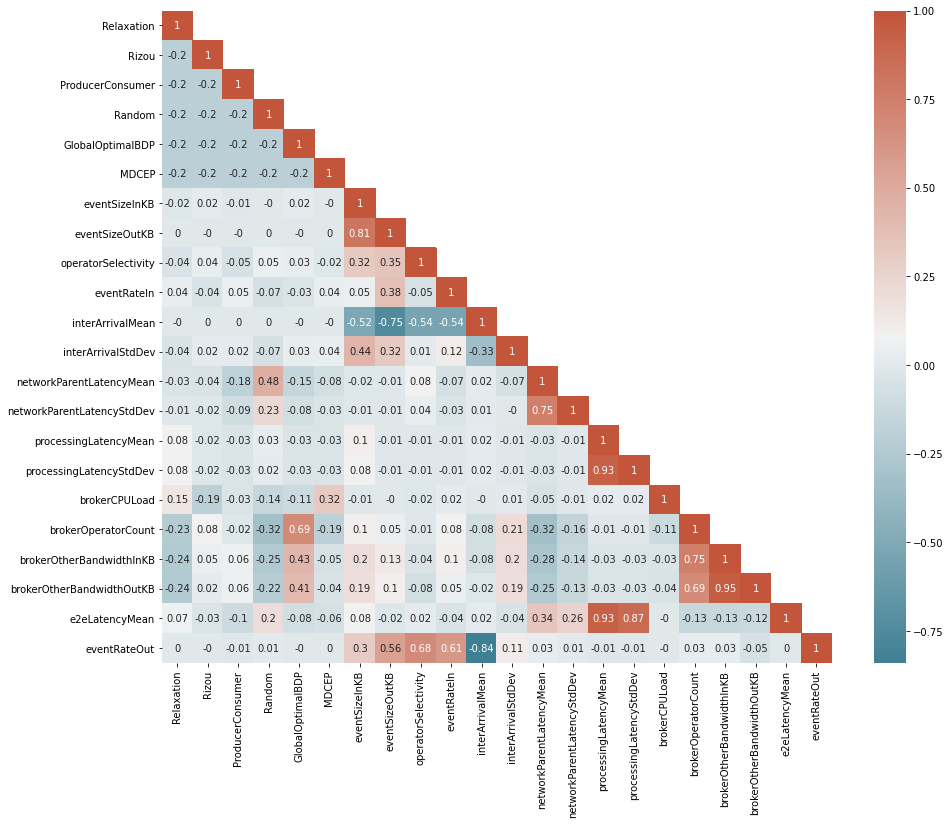

In [2]:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # plot heatmap to visualize feature-wise correlations
    # -> guidance for feature selection: select relevant features and avoid selecting highly correlated features
    df = pd.read_csv(sample_filepath + '/combined_samples.csv', sep=';')
    # Using Pearson Correlation
    plt.figure(figsize=(15, 12))
    cor = df.drop('brokerThreadCount', axis=1).corr()
    cor = cor.applymap(lambda x: round(x, 2))
    # only use lower triangle matrix
    cor_lt = cor.where(np.tril(np.ones(cor.shape)).astype(np.bool))
    colors = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(cor_lt, annot=True, cmap=colors)
    plt.savefig(sample_filepath + '/feature_correlation_heatmap.pdf', dpi=500)
    plt.show()
